In [1]:
#imports
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

## Load and Normalize Data

In [ ]:
#Load Data
merged_data_clean_relevant = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/merged_data_clean_relevant.csv")
relationship_status = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/relationship_status.csv")

print(relationship_status.sum())
print(merged_data_clean_relevant)

In [23]:
#normalize data
scaler = RobustScaler()
merged_data_clean_scaled = scaler.fit_transform(merged_data_clean_relevant)

#Dataframe with normalized columsn and header
merged_data_clean_scaled_dataframe = pd.DataFrame(merged_data_clean_scaled, columns=merged_data_clean_relevant.columns)

## Train-/Test-Split


In [24]:
relationship_array = relationship_status["Relationship_Status"]

In [34]:
# Split into training and test sets by keeping the ration of people in a relationship to people not the same for training and test set. 
X_train, X_test, Y_train, Y_test = train_test_split(merged_data_clean_scaled, relationship_array, test_size=0.2, stratify=relationship_array, random_state=42)

In [36]:
# Optional: Check class proportions
import numpy as np
print("Class distribution in y_train:", dict(zip(*np.unique(Y_train, return_counts=True))))
print("Class distribution in y_test:", dict(zip(*np.unique(Y_test, return_counts=True))))

Class distribution in y_train: {0: 54, 1: 125}
Class distribution in y_test: {0: 14, 1: 31}


## Training

### Logistic Regression

In [6]:
#set up learning function 
#set up cross validation. 
# Train

# set hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models
ridge_model = LogisticRegressionCV(penalty="l2", n_jobs = 16, max_iter=max_iter, fit_intercept=False, random_state=1, solver='saga', cv=n_folds, Cs=n_alphas)

# INSERT YOUR CODE HERE
logreg_ridge_cv = ridge_model.fit(X_train, Y_train)

In [7]:
# Cross-validated accuracy scores for each fold
cv_scores = logreg_ridge_cv.scores_[1]  # For the positive class (1)

# Mean accuracy across folds
mean_cv_accuracy = cv_scores.mean()

# Print the cross-validated accuracy
print(f"Mean cross-validated accuracy: {mean_cv_accuracy:.4f}")

Mean cross-validated accuracy: 0.6471


### Random Forest

#### Model Training using GridSearch with Cross Validation

In [37]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'n_estimators': [10, 25, 50, 100, 150],
    'max_features': ['sqrt', 'log2',None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42), #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    param_grid=param_grid,
    cv=5,       # Cross-validation folds
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 150}


#### Evaluation on Test Set

In [43]:
# Use the best model for predictions
best_rf_model = grid_search.best_estimator_

# Test Model on Test Set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model
results = classification_report(Y_test, y_pred, output_dict=True)
print(results)
print("weighted average F1 Score: " + str(results["weighted avg"]["f1-score"]))


{'0': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1-score': 0.5, 'support': 14.0}, '1': {'precision': 0.7714285714285715, 'recall': 0.8709677419354839, 'f1-score': 0.8181818181818182, 'support': 31.0}, 'accuracy': 0.7333333333333333, 'macro avg': {'precision': 0.6857142857142857, 'recall': 0.6497695852534562, 'f1-score': 0.6590909090909092, 'support': 45.0}, 'weighted avg': {'precision': 0.7180952380952381, 'recall': 0.7333333333333333, 'f1-score': 0.7191919191919193, 'support': 45.0}}
weighted average F1 Score: 0.7191919191919193


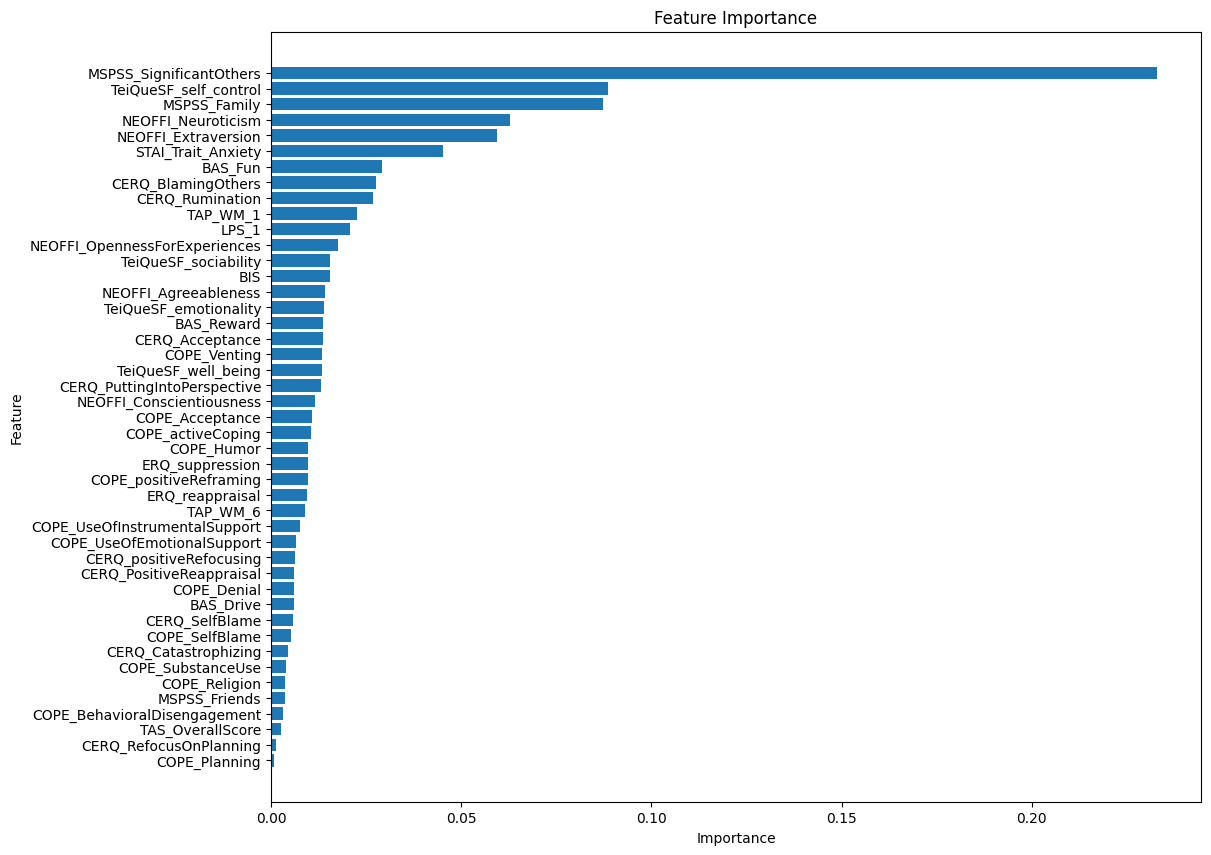

In [39]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': merged_data_clean_scaled_dataframe.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Initialize the Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,     # Number of trees
    max_depth=3,       # Maximum depth of trees
    random_state=42,      # Ensures reproducibility
    n_jobs=-1,
    min_samples_leaf= 5,
    min_samples_split=2,
    class_weight='balanced'      #account for imbalanced dataset
)


# Set up Stratified Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(rf_model, X_train, Y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

# Print Cross-Validation Results
print("Cross-Validation weighted F1 Scores:", cv_scores)
print(f"weighted f1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

In [44]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Dummy Classifier Training with Cross-Validation
def train_dummy_classifier_cv(X_train, Y_train, X_test, Y_test, cv=5):
    # Initialize Dummy Classifier
    dummy_clf = DummyClassifier(strategy="stratified")  # Predicts the most frequent class

    # Perform Cross-Validation
    cv_scores = cross_val_score(dummy_clf, X_train, Y_train, cv=cv, scoring="f1_weighted")

    # Train on full dataset to generate a classification report
    dummy_clf.fit(X_train, Y_train)

    #Predict on Test Set
    y_pred_dummy = dummy_clf.predict(X_test)
    dummy_report = classification_report(Y_test, y_pred_dummy, output_dict=True)
    
    print("Dummy Classifier Cross-Validation Performance:")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")
    print(dummy_report)
    print("weighted average F1 Score: " + str(dummy_report["weighted avg"]["f1-score"]))
    
    return cv_scores, dummy_report

# Train Dummy Classifier using Cross-Validation
dummy_cv_scores, dummy_cv_report = train_dummy_classifier_cv(X_train, Y_train, X_test, Y_test, cv=5)

Dummy Classifier Cross-Validation Performance:
Mean CV Accuracy: 0.5655 (± 0.0701)
{'0': {'precision': 0.38461538461538464, 'recall': 0.35714285714285715, 'f1-score': 0.3703703703703704, 'support': 14.0}, '1': {'precision': 0.71875, 'recall': 0.7419354838709677, 'f1-score': 0.7301587301587302, 'support': 31.0}, 'accuracy': 0.6222222222222222, 'macro avg': {'precision': 0.5516826923076923, 'recall': 0.5495391705069125, 'f1-score': 0.5502645502645503, 'support': 45.0}, 'weighted avg': {'precision': 0.6147970085470086, 'recall': 0.6222222222222222, 'f1-score': 0.6182245737801294, 'support': 45.0}}
weighted average F1 Score: 0.6182245737801294


## Analysis of Important Features